In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from timeit import default_timer as time
from torchinfo import summary

In [2]:
# Define the transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
data_dir = 'Documents/miniproject/Rice Leaf Disease Images'  # Update this to your actual path
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
all_data = [(path, class_idx) for path, class_idx in dataset.samples]
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
train_data, val_data = train_test_split(all_data, test_size=0.2, random_state=42)

# Print some statistics
print(f"Total dataset size: {len(all_data)}")
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")


Total dataset size: 6382
Training set size: 5105
Validation set size: 1277


In [12]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_idx = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx,



In [13]:
# Create datasets
train_dataset = CustomDataset(train_data, transform=train_transforms)
val_dataset = CustomDataset(val_data, transform=val_transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [22]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

class CustomResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet50, self).__init__()
        # Load the pre-trained ResNet-50 model
        self.resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Freeze the parameters in the base layers
        for param in self.resnet50.parameters():
            param.requires_grad = False

        # Modify the final fully connected layer to match the number of classes
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

num_classes = 5 
model = CustomResNet50(num_classes=num_classes)

In [23]:
# Model summary
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
CustomResNet50 (CustomResNet50)               [32, 3, 224, 224]    [32, 5]              --                   Partial
├─ResNet (resnet50)                           [32, 3, 224, 224]    [32, 5]              --                   Partial
│    └─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 5

In [24]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               epoch: int):
  # put model to train mode
  model.train()

  # set train loss
  train_loss = 0
  train_acc = 0

  #loop through dataloader batches

  for X,y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
    # forward passs
    X,y = X.to(device),y.to(device)
    y_logit = model(X)

    # calculate the loss

    loss=loss_fn(y_logit,y)
    train_loss += loss.item()


    #optimizer zero grad

    optimizer.zero_grad()

    #loss backward

    loss.backward()

    #optimizer step
    optimizer.step()

    #calculate and accumulate accuracy metric across all batches
    y_pred_label = torch.argmax(torch.softmax(y_logit,dim=1),dim=1)
    train_acc +=(y_pred_label == y).sum().item()/len(y_logit)

  # return train loss and train accuracy
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss,train_acc

In [25]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              epoch: int):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for X,y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Testing"):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [26]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: optim.Optimizer,
          # scheduler: optim.lr_scheduler._LRScheduler,
          epochs: int = 5,
          device: torch.device = 'cuda'):
    # Empty list for training and test loss
    result = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           epoch=epoch)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        epoch=epoch)

        # Printing what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update result
        result["train_loss"].append(train_loss)
        result["train_acc"].append(train_acc)
        result["test_loss"].append(test_loss)
        result["test_acc"].append(test_acc)
        # scheduler.step()

    return result

In [28]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the number of epochs
num_epochs = 13 # Increase this if necessary

# Define loss function, optimizer, and scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
start_time = time()
# Train the model
model_result=train(model=model,
      train_dataloader=train_loader,
      test_dataloader=val_loader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      # scheduler=scheduler,
      epochs=num_epochs,
      device=device)
end_time = time()
print(f"Total training time : {end_time - start_time:.3f}  seconds")

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0476 | train_acc: 0.7199 | test_loss: 0.9205 | test_acc: 0.7752


Epoch 2/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.8794 | train_acc: 0.7488 | test_loss: 0.7746 | test_acc: 0.7964


Epoch 3/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.7696 | train_acc: 0.7791 | test_loss: 0.6959 | test_acc: 0.8144


Epoch 4/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.6993 | train_acc: 0.7930 | test_loss: 0.6354 | test_acc: 0.8285


Epoch 5/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.6561 | train_acc: 0.8022 | test_loss: 0.5825 | test_acc: 0.8387


Epoch 6/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.6113 | train_acc: 0.8111 | test_loss: 0.5568 | test_acc: 0.8394


Epoch 7/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.5845 | train_acc: 0.8203 | test_loss: 0.5192 | test_acc: 0.8529


Epoch 8/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.5626 | train_acc: 0.8220 | test_loss: 0.5052 | test_acc: 0.8473


Epoch 9/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.5377 | train_acc: 0.8368 | test_loss: 0.4865 | test_acc: 0.8583


Epoch 10/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.5217 | train_acc: 0.8404 | test_loss: 0.4721 | test_acc: 0.8653


Epoch 11/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 11/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.5043 | train_acc: 0.8400 | test_loss: 0.4502 | test_acc: 0.8653


Epoch 12/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 12/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.4865 | train_acc: 0.8507 | test_loss: 0.4307 | test_acc: 0.8794


Epoch 13/13 - Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 13/13 - Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.4832 | train_acc: 0.8485 | test_loss: 0.4142 | test_acc: 0.8818
Total training time : 7279.369  seconds


In [29]:
from typing import Dict, List
def plot_loss_curves(results: Dict [str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
   
    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

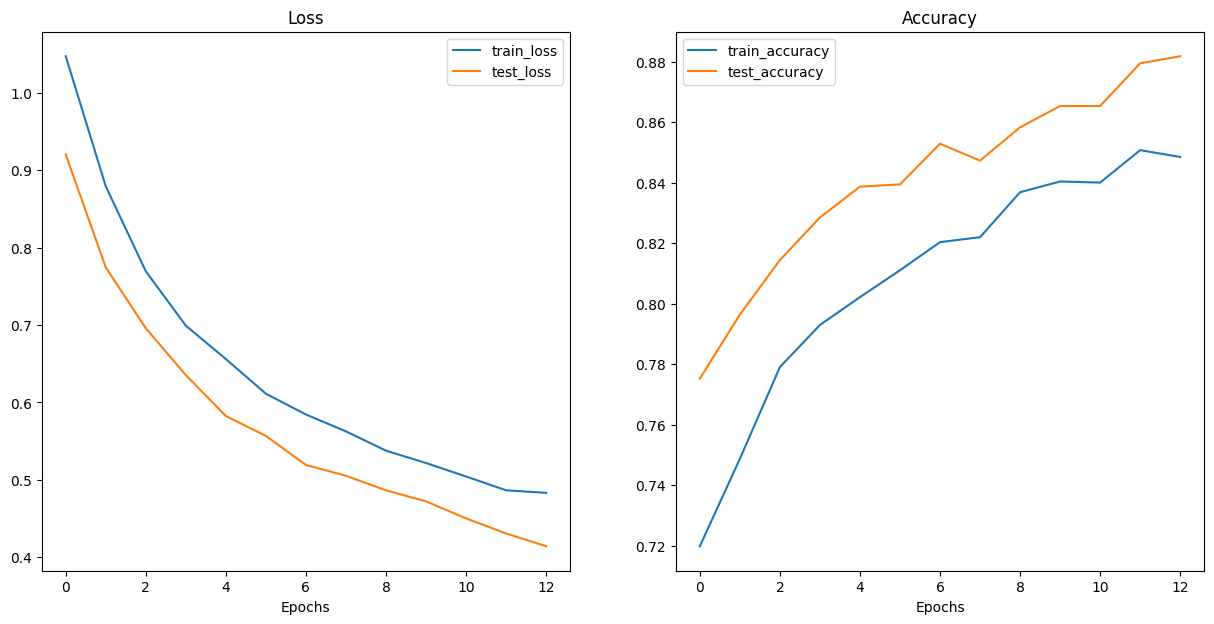

In [30]:
import matplotlib.pyplot as plt
plot_loss_curves(model_result)

In [31]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "myresnetmodel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\myresnetmodel.pth


In [33]:
loaded_model_1 =CustomResNet50(num_classes=num_classes)

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

CustomResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [34]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
y_true = []
loaded_model_1.eval()
with torch.inference_mode():
  for X, y in tqdm(val_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = loaded_model_1(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
      # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    y_true.extend(y.cpu().numpy())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.tensor(y_true)

Making predictions:   0%|          | 0/20 [00:00<?, ?it/s]

In [35]:
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [37]:
data_dir = 'Documents/miniproject/Rice Leaf Disease Images'  # Update this to your actual path
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
class_names = dataset.classes

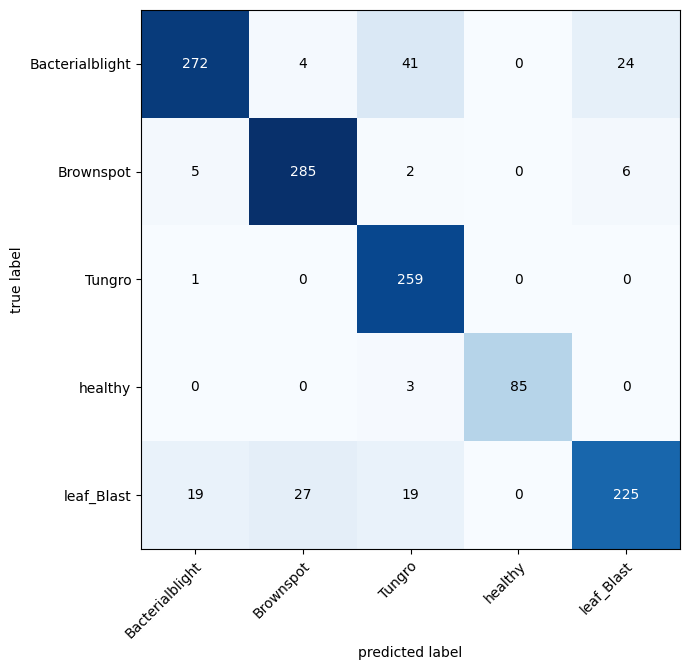

In [39]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=5, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_true_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);